In [1]:
# install dependencies
%pip install numpy
%pip install matplotlib
%pip install torch torchvision
%pip install opencv-python
%pip install Pillow
%pip install imutils
%pip install super_gradients
%pip install albumentations 
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import random
from typing import List,Tuple
import requests

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PurePath
import pathlib

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image

import albumentations as A

from imutils import paths

import textwrap

from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training import models
from super_gradients.training.utils.callbacks import Phase

The console stream is logged into C:\Users\yewentai\sg_logs\console.log


[2023-12-17 12:37:14] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-12-17 12:37:15] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-12-17 12:37:15,261] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-12-17 12:37:19] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-17 12:37:19] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-17 12:37:19] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-12-17 12:37:19] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


# Number of classes

Simple utility to fetch the number of classes.

In [3]:
def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Example usage
parent_dir = "./data/train"
num_species = count_subdirectories(parent_dir)
print(f"Number of subdirectories in {parent_dir}: {num_species}")

Number of subdirectories in ./data/train: 525


# Config 

This holds variables for the notebook.

Define the model, training params, image type, number of classes, and  relevant directories in this class.

In [12]:
class config:
    # specify the paths to datasets
    ROOT_DIR = Path('./data/')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('valid')

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 128
    MODEL_NAME = 'resnet50'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_resnet50_train_params'
    
    NUM_CLASSES = num_species
    
    CHECKPOINT_DIR = ROOT_DIR.joinpath('checkpoints')


# Plot random images

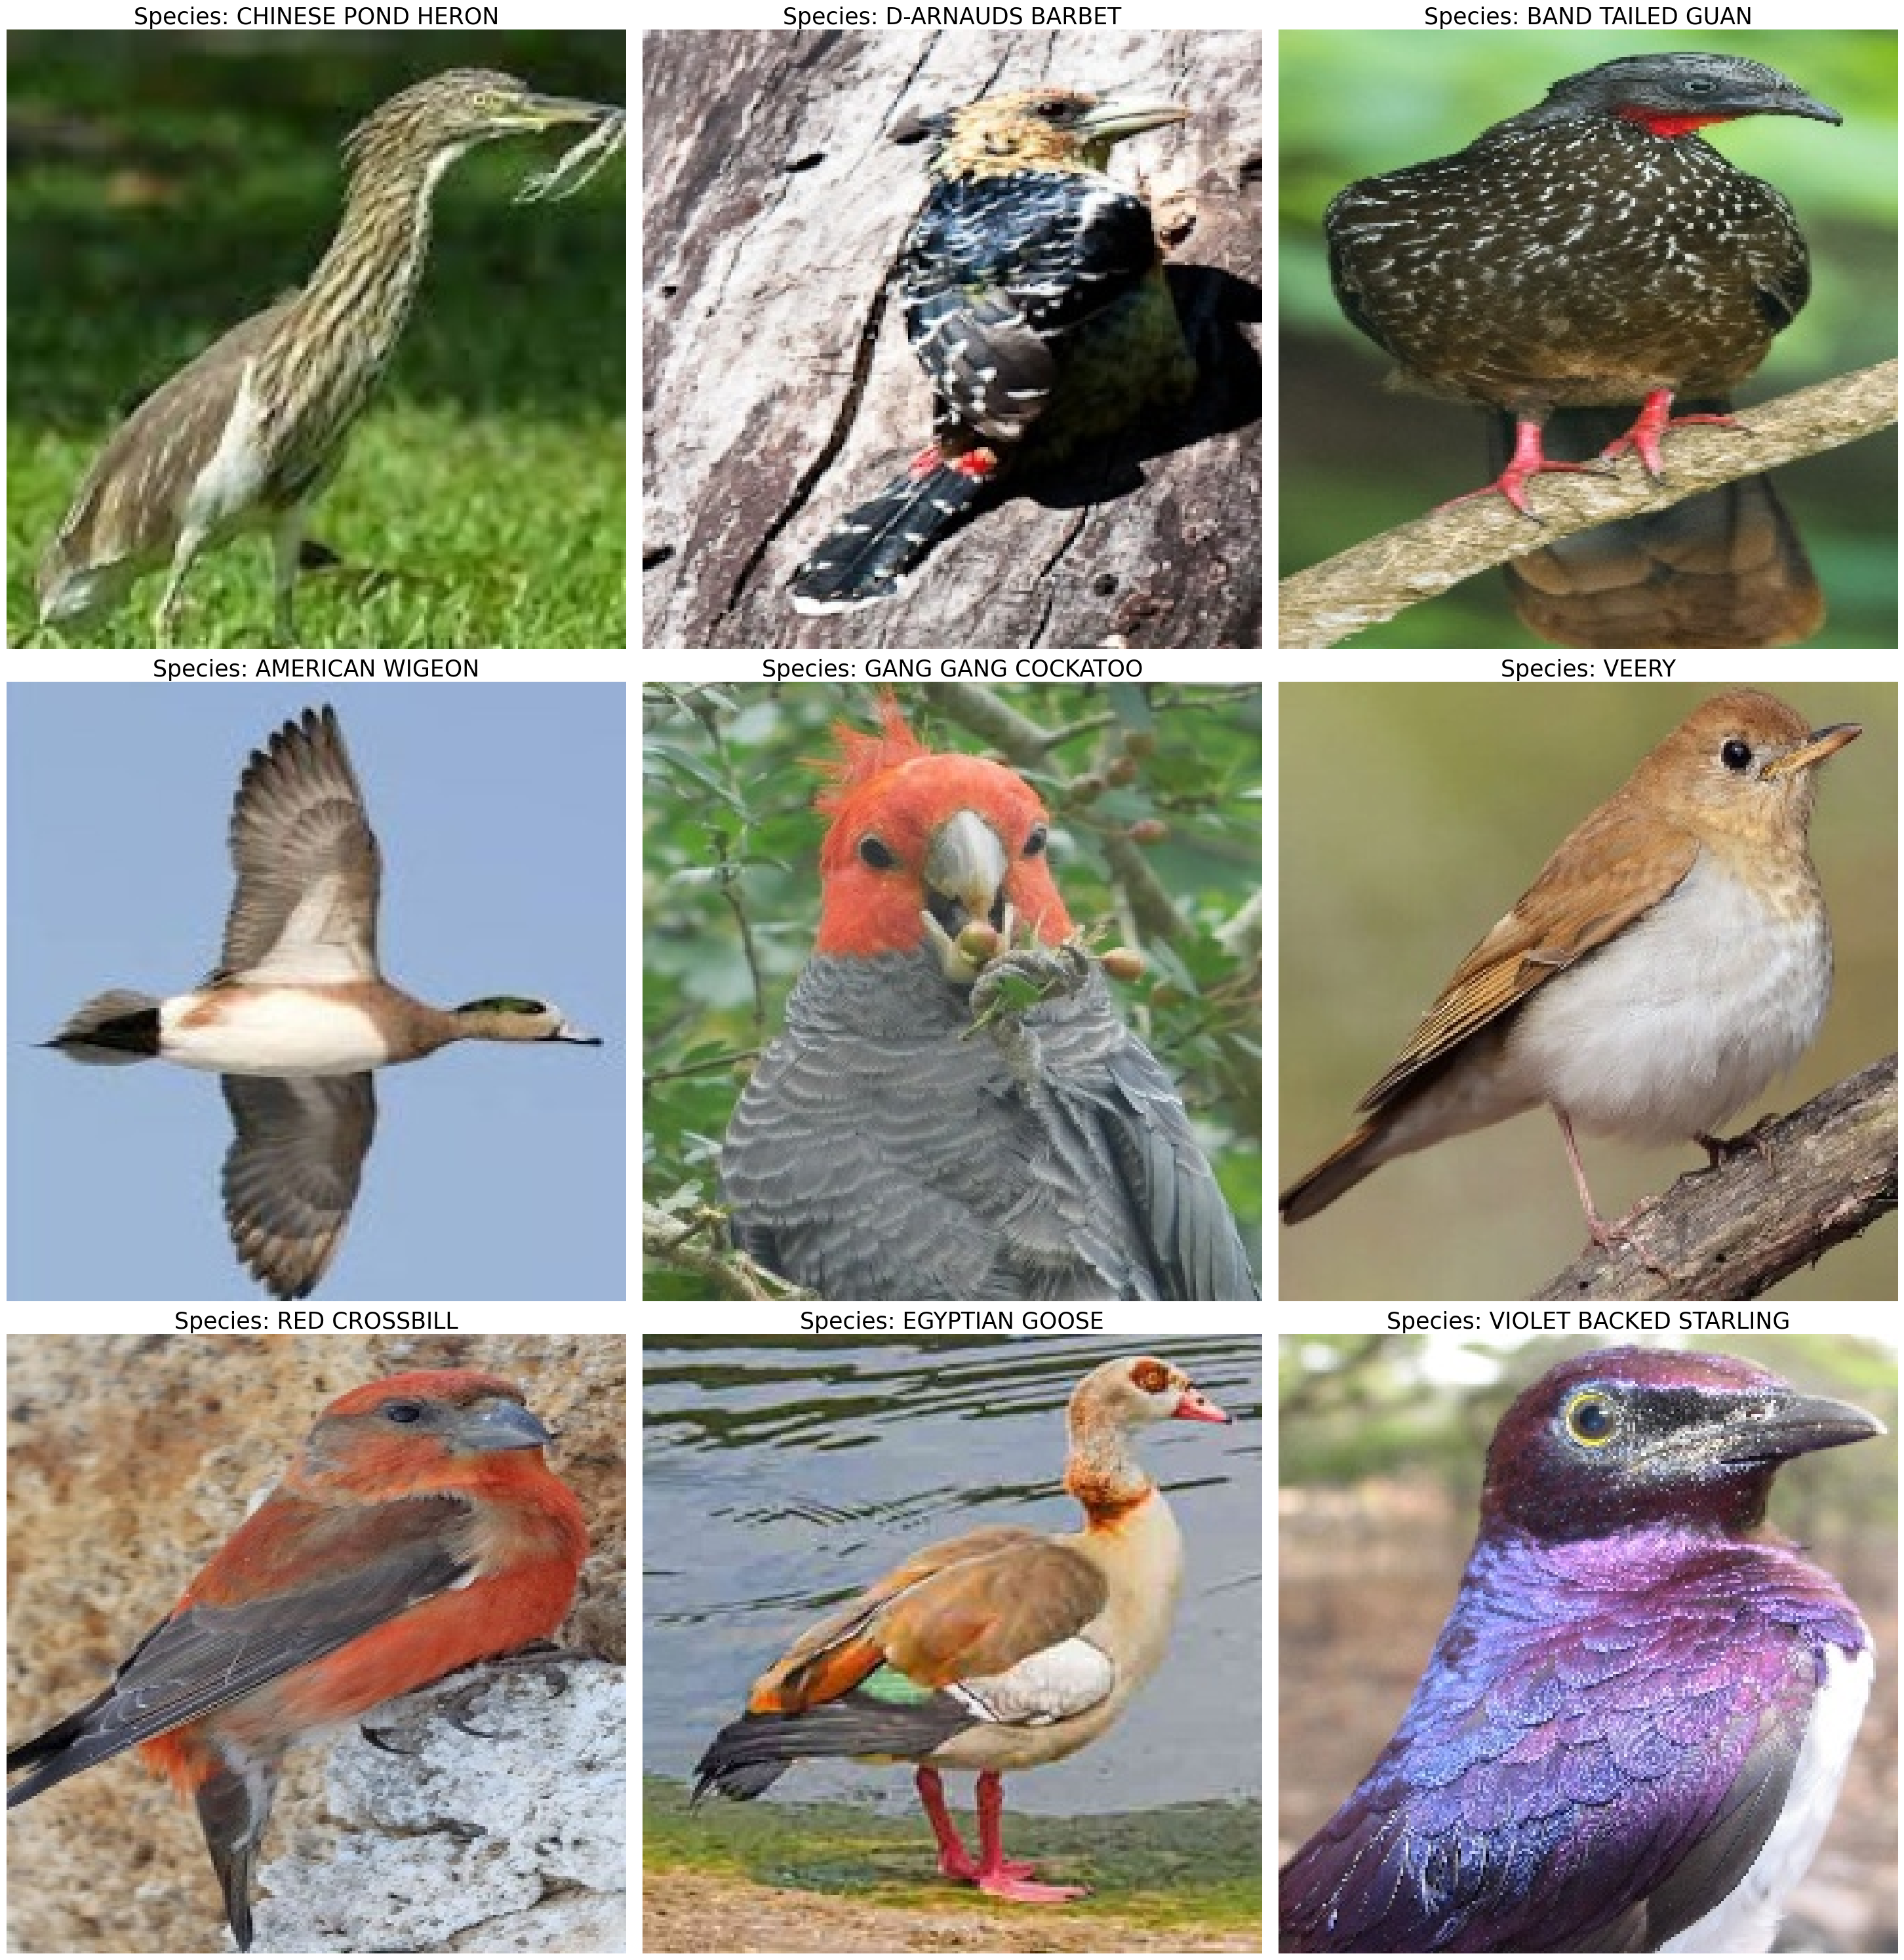

In [6]:
train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=9)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/3))
    num_cols = 3
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Species: {label}", fontsize=25)
        axs[i].axis('off')
    
    # save the sample images
    plt.savefig('./figures/sample_images.svg', format='svg', dpi=1200)

examine_images(train_image_path_sample)

# Augmentations


In [7]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.5)
random_rotation = transforms.RandomRotation(degrees=180)
random_crop = transforms.RandomCrop(size=(170,170))
random_erasing = transforms.RandomErasing()
augmix = transforms.AugMix(severity = 4, mixture_width=4, alpha=0.65)

# initialize our training and validation set data augmentation pipeline
train_transforms = transforms.Compose([
  resize, 
  augmix,
  center_cropper,
  random_crop,
  random_horizontal_flip,
  random_vertical_flip,
  random_rotation,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, make_tensor, normalize])

# Show what one image looks like after augmentation

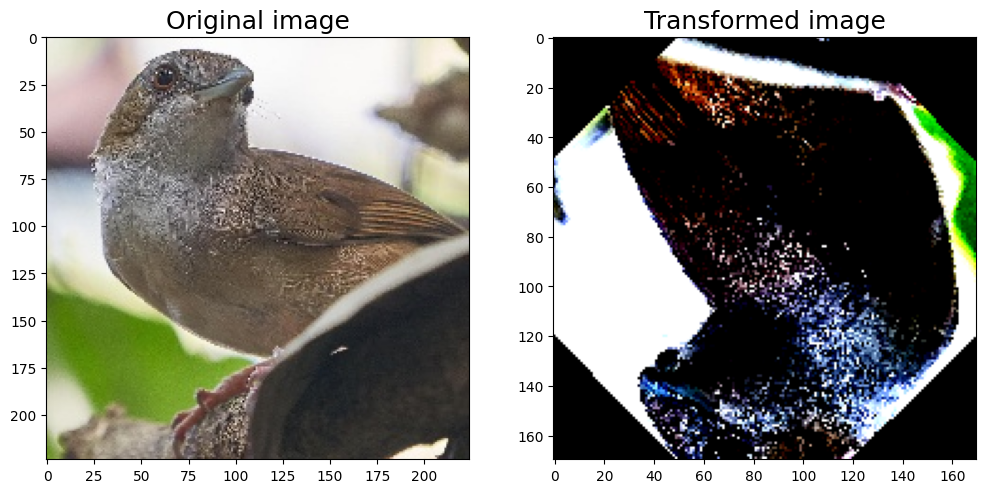

In [8]:
def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """
    # Apply the transform to the image
    if isinstance(transform, torchvision.transforms.Compose):
        # Apply PyTorch transform to image array
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
        # Apply Albumentations transform to image array
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    # Convert the image tensor to a numpy array and transpose the axes to (height, width, channels)
    img_array = transformed_image.numpy().transpose((1, 2, 0))

    # Clip the pixel values to the range [0, 1]
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18
    
    if original_image is None:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the transformed image in the first column.
        ax[0].imshow(image)
    else:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the original image in the first column.
        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)
        
        # Show the transformed image in the second column.
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
img = Image.open(train_image_path_list[0])
img_array = apply_transform(img, train_transforms)

visualize_transform(img_array, original_image=img)

# Datasets and Dataloadrer

In [13]:
def create_dataloaders(
    train_dir: str, 
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int, 
    num_workers: int=2
):
  """Creates training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names).
  """
  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)  

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")

  # Get class names
  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")

  # Turn images into data loaders
  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [14]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.VAL_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=config.BATCH_SIZE)

NUM_CLASSES = len(class_names)

FileNotFoundError: Found no valid file for the classes PLUSH CRESTED JAY. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

# Training Params

In [ ]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)

In [ ]:
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=7, verbose=False)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="LabelSmoothingCrossEntropyLoss", mode="min", patience=7, verbose=False)

training_params["train_metrics_list"] = [Accuracy(), Top5()]
training_params["valid_metrics_list"] = [Accuracy(), Top5()]
training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]

# Set the silent mode to True to reduce clutter in the notebook, you can turn it on to see the full output
training_params["silent_mode"] = True

# Turn off the use of exponential moving average and zero weight decay on bias and batch norm
# training_params['ema'] = False
training_params['zero_weight_decay_on_bias_and_bn'] = False
training_params["optimizer"] = 'Adam'

training_params["criterion_params"] = {'smooth_eps': 0.20}
training_params["max_epochs"] = 25
training_params["initial_lr"] = 0.0001

# Get model

In [ ]:
# get pretrained model from torchvision
# model = models.get(config.MODEL_NAME, num_classes = config.NUM_CLASSES, pretrained_weights='imagenet')

# load trained model from checkpoint
model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path="checkpoints/0_Baseline_Experiment/RUN_20231214_031615_769270/ckpt_best.pth")

# Instantiate trainer

In [ ]:
model_trainer = Trainer(experiment_name='ResNet50', ckpt_root_dir=config.CHECKPOINT_DIR)

# Train model

In [ ]:
model_trainer.train(model=model, 
              training_params=training_params, 
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

In [ ]:
import os
trained_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(model_trainer.checkpoints_dir_path, "average_model.pth"))

# Evaluate on test set

In [ ]:
model_trainer.test(model=trained_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy', 'Top5'])

# Plot predictions

In [ ]:
import glob # for reading files in a directory

def pred_and_plot_image(image_path: str, 
                        subplot: Tuple[int, int, int],  # subplot tuple for `subplot()` function
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = trained_model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
        img = Image.open(image_path)
    else: 
        img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name

    # plot image with predicted label and probability 
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=20)))  # wrap text using textwrap.wrap() function
    plt.axis(False)
    

def plot_random_test_images(model):
    num_images_to_plot = 30
    test_image_path_list = list(Path(config.TEST_DIR).glob("*/*.jpg")) # get list all image paths from test data 
    test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                           k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

    # set up subplots
    num_rows = int(np.ceil(num_images_to_plot / 5))
    fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    ax = ax.flatten()

    # Make predictions on and plot the images
    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model, 
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 5, i+1),  # subplot tuple for `subplot()` function
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=1)
    plt.show()
    # save the predictions plot
    plt.savefig('./figures/predictions.svg', format='svg', dpi=1200)

# Predict on images from internet

In [ ]:
plot_random_test_images(trained_model)

In [ ]:
#Baltimore oriole
image_url = 'https://www.allaboutbirds.org/guide/assets/og/75258971-1200px.jpg'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))

In [ ]:
#Sri Lankan blue magpie
image_url = 'https://cdn.download.ams.birds.cornell.edu/api/v1/asset/252002651/1800'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))